C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


   Sugar_Concentration_g/L      mean       std  mean_corrected
0                     0.00  0.041333  0.001155        0.000000
1                     1.13  0.239667  0.041041        0.198333
2                     2.25  0.404667  0.095699        0.363333
3                     3.38  0.649000  0.187561        0.607667
4                     4.50  0.845333  0.200241        0.804000


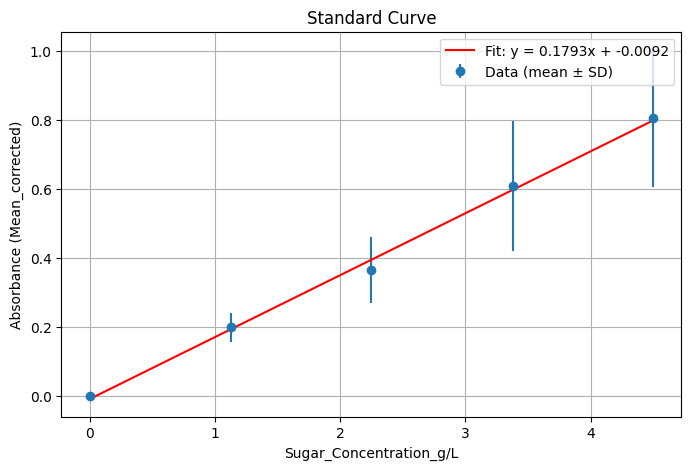

Line formula: Absorbance = 0.1793 * Sugar_Concentration_g/L + -0.0092


In [2]:
# MERGE OF RAW DATA AND METADATA

import pandas as pd

    # Load raw data and metadata
raw_df = pd.read_excel('RawData_DNS_002_Hyd_013_1h.xlsx')
meta_df = pd.read_excel('MetaData_DNS_002_Hyd_013_1h.xlsx')

    # Merge: keep all metadata columns, add only 'absorbance' from raw data, matched by 'well_number'
merged_df = meta_df.merge(
raw_df[['Well_number', 'Absorbance']],
on='Well_number',
how='left'
    )

    # Drop the 'Absorbance_x' column if it exists
if 'Absorbance_x' in merged_df.columns: merged_df = merged_df.drop(columns=['Absorbance_x'])

# CALCULATION OF STANDARD CURVE

    # Filter only rows where Sample_Type is 'Standard'
standards_df = merged_df[merged_df['Sample_Type'] == 'Standard']

    # Calculate mean and standard deviation by Sugar Concentration
summarystandard_df = standards_df.groupby('Sugar_Concentration_g/L')['Absorbance_y'].agg(['mean', 'std']).reset_index()

    # Subtract the mean absorbance of Sugar_Concentration_g/L == 0 from all mean values
blank_mean = summarystandard_df.loc[summarystandard_df['Sugar_Concentration_g/L'] == 0, 'mean'].values[0]
summarystandard_df['mean_corrected'] = summarystandard_df['mean'] - blank_mean

    # Display the summary DataFrame
print(summarystandard_df)

import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

    # Line fit (linear regression)
x = summarystandard_df['Sugar_Concentration_g/L']
y = summarystandard_df['mean_corrected']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=summarystandard_df['std'], fmt='o', label='Data (mean ± SD)')
plt.plot(x, slope * x + intercept, 'r-', label=f'Fit: y = {slope:.4f}x + {intercept:.4f}')
plt.xlabel('Sugar_Concentration_g/L')
plt.ylabel('Absorbance (Mean_corrected)')
plt.title('Standard Curve')
plt.legend()
plt.grid(True)
plt.show()

    # Print the line formula
print(f"Line formula: Absorbance = {slope:.4f} * Sugar_Concentration_g/L + {intercept:.4f}")

    # Define the line formula as a function object
def standard_curve_formula(absorbance):
    """Calculate Sugar_Concentration_g/L from absorbance using the fitted standard curve."""
    return(absorbance - intercept) / slope

    # Example usage:
    # sugar_conc = standard_curve_formula(absorbance_value)

    # Get Plate ID value (assuming it's a single value in the metadata)
plate_id = merged_df['Plate_ID'].iloc[0] if 'Plate_ID' in merged_df.columns else 'Unknown'

    # Name the new DataFrame accordingly
standard_curve_data_name = f"Standard_curve_data_{plate_id}"
globals()[standard_curve_data_name] = summarystandard_df

    # Save standard curve data to Excel
summarystandard_df.to_excel(f"{standard_curve_data_name}.xlsx", index=False)


In [10]:
# GENERATE THE 'Cleaned_merged_DataFrame' by calculating blank and dilution factor-corrected absorbance and calculating the Sugar_concentration_g/L by applying the standard curve formula

        # Calculate the Sugar_concentration_g/L for each row in the merged DataFrame by using the standard curve formula

                # Filter only records where Sugar_Concentration_g/L is NaN
cleaned_df = merged_df[merged_df['Sugar_Concentration_g/L'].isna()].copy()

                # Calculate Sugar_concentration_g/L using the standard_curve_formula and Absorbance_y
cleaned_df['Sugar_Concentration_g/L'] = cleaned_df['Absorbance_y'].apply(standard_curve_formula)

# Multiply Sugar_Concentration_g/L by Dilution_Factor and store in a new column
cleaned_df['Sugar_Concentration_g/L_dil'] = cleaned_df['Sugar_Concentration_g/L'] * cleaned_df['Dilution_Factor']

# Create a new column for Mean_Blank_sugar_Concentration_g/L

# Calculate mean Sugar_Concentration_g/L for blanks grouped by Substrate, Substrate_concentration_%, and Time_h
blank_means = cleaned_df[cleaned_df['Sample_Type'] == 'Blank'].groupby(
    ['Substrate', 'Substrate_concentration_%', 'Time_h']
)['Sugar_Concentration_g/L_dil'].mean().reset_index().rename(
    columns={'Sugar_Concentration_g/L_dil': 'Mean_Blank_sugar_concentration_g/L_dil'}
)

print(blank_means)

# Merge the mean blank values back into cleaned_df
cleaned_df = cleaned_df.merge(
    blank_means,
    on=['Substrate', 'Substrate_concentration_%', 'Time_h'],
    how='left'
)

# Create the corrected sugar concentration column multiply by its dilution factor and subtract the mean blank value

cleaned_df['Sugar_Concentration_g/L_corrected'] = (cleaned_df['Sugar_Concentration_g/L_dil'] - cleaned_df['Mean_Blank_sugar_concentration_g/L_dil']
)

# Keep only records where Sample_Type is 'Unknown'
Technical_cleaned_df = cleaned_df[cleaned_df['Sample_Type'] == 'Unknown'].copy()

# Name the technical DataFrame accordingly
Technical_Cleaned_merged_data_name = f"Technical_cleaned_merged_Data_{plate_id}"
globals()[Technical_Cleaned_merged_data_name] = Technical_cleaned_df

    # Save cleaned data with technical replicates to Excel
Technical_cleaned_df.to_excel(f"{Technical_Cleaned_merged_data_name}.xlsx", index=False)

# Keep only records where Sample_Type is 'Unknown'
Final_cleaned_df = cleaned_df[cleaned_df['Sample_Type'] == 'Unknown'].copy()

# Create Final_cleaned_df with technical replicate means
group_cols = [
    'Treatment_Enzyme', 'Bio_Rep', 'Substrate', 'Substrate_concentration_%',
    'Enzyme_load_mg_g', 'Time_h', 'Agitation_rpm', 'Plate_ID'
]

Final_cleaned_df = (cleaned_df
    .groupby(group_cols, as_index=False)
    .agg({'Sugar_Concentration_g/L_corrected': 'mean'})
    .rename(columns={'Sugar_Concentration_g/L_corrected': 'Sugar_Concentration_g/L_corrected_Techmean'})
)

# Name the new DataFrame accordingly
Final_cleaned_merged_data_name = f"Final_cleaned_merged_Data_{plate_id}"
globals()[Final_cleaned_merged_data_name] = Final_cleaned_df

Final_cleaned_df = Final_cleaned_df.rename(
    columns={'Sugar_Concentration_g/L_corrected_Techmean': 'Sugar_Concentration_g_L_corrected_Techmean'}
)

# Ensure Plate_ID is present in Final_cleaned_df
if 'Plate_ID' not in Final_cleaned_df.columns or Final_cleaned_df['Plate_ID'].isnull().any():
    Final_cleaned_df = Final_cleaned_df.merge(
        cleaned_df[['Treatment_Enzyme', 'Bio_Rep', 'Substrate', 'Substrate_concentration_%',
                    'Enzyme_load_mg_g', 'Time_h', 'Agitation_rpm', 'Plate_ID']].drop_duplicates(),
        on=['Treatment_Enzyme', 'Bio_Rep', 'Substrate', 'Substrate_concentration_%',
            'Enzyme_load_mg_g', 'Time_h', 'Agitation_rpm'],
        how='left'
    )

    # Save cleaned data to Excel
Final_cleaned_df.to_excel(f"{Final_cleaned_merged_data_name}.xlsx", index=False)

print(Final_cleaned_df.head())

  Substrate  Substrate_concentration_%  Time_h  \
0  RiceBran                         10       1   

   Mean_Blank_sugar_concentration_g/L_dil  
0                                2.595883  
          Treatment_Enzyme  Bio_Rep Substrate  Substrate_concentration_%  \
0  A. niger var. phoenicis      1.0  RiceBran                         10   
1  A. niger var. phoenicis      1.0  RiceBran                         10   
2  A. niger var. phoenicis      1.0  RiceBran                         10   
3  A. niger var. phoenicis      2.0  RiceBran                         10   
4  A. niger var. phoenicis      2.0  RiceBran                         10   

  Enzyme_load_mg_g  Time_h  Agitation_rpm         Plate_ID  \
0            0.861       1            100  DNS_002_Hyd_013   
1            0.068       1            100  DNS_002_Hyd_013   
2            0.137       1            100  DNS_002_Hyd_013   
3            0.861       1            100  DNS_002_Hyd_013   
4            0.068       1            100  D

          Treatment_Enzyme Substrate  Substrate_concentration_%  \
0  A. niger var. phoenicis  RiceBran                         10   
1  A. niger var. phoenicis  RiceBran                         10   
2  A. niger var. phoenicis  RiceBran                         10   
3          P. parvofructum  RiceBran                         10   
4          P. parvofructum  RiceBran                         10   
5          P. parvofructum  RiceBran                         10   
6            Thermo_Amy_AB  RiceBran                         10   

  Enzyme_load_mg_g  Time_h  Agitation_rpm         Plate_ID  \
0            0.861       1            100  DNS_002_Hyd_013   
1            0.068       1            100  DNS_002_Hyd_013   
2            0.137       1            100  DNS_002_Hyd_013   
3            0.915       1            100  DNS_002_Hyd_013   
4            0.068       1            100  DNS_002_Hyd_013   
5            0.137       1            100  DNS_002_Hyd_013   
6            0.068       1   

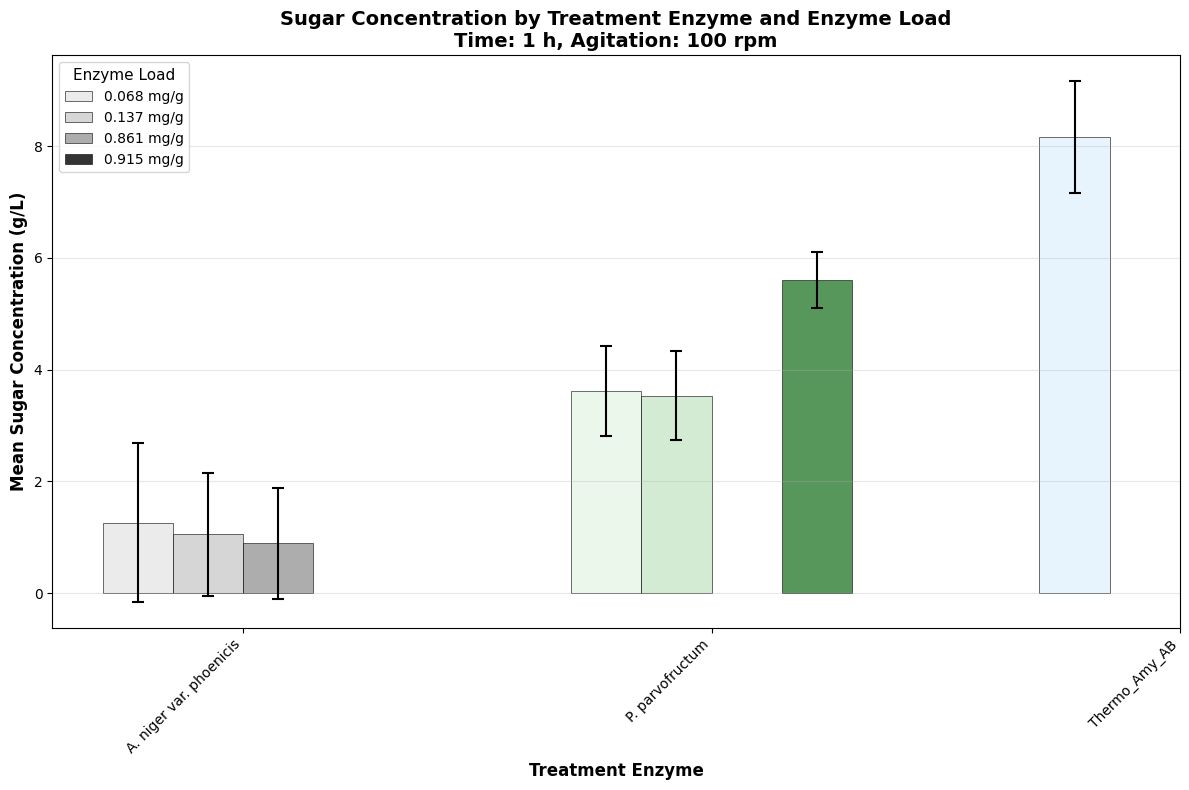

In [17]:
# VISUALIZATION PER EXPERIMENTAL CONDITIONS

# Define the columns to group by
group_cols = [
    'Treatment_Enzyme', 'Substrate', 'Substrate_concentration_%',
    'Enzyme_load_mg_g', 'Time_h', 'Agitation_rpm', 'Plate_ID'
]

# Group and calculate mean and std of mean_Sugar_Concentration_g_L
visualization_per_experiment_df = (
    Final_cleaned_df
    .groupby(group_cols)['Sugar_Concentration_g_L_corrected_Techmean']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'mean_of_bio_Rep_Sugar_Concentration_g_L', 'std': 'std_of_bio_rep_Sugar_Concentration_g_L'})
)

# Name the new DataFrame accordingly
visualization_data_name = f"visualization_data_{plate_id}"
globals()[visualization_data_name] = visualization_per_experiment_df

# Save to new Excel file
visualization_per_experiment_df.to_excel(f"{visualization_data_name}.xlsx", index=False)

print(visualization_per_experiment_df)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define color mapping for each enzyme with intensity variations
enzyme_colors = {
    'A. niger var. phoenicis': ['#E6E6E6', '#CCCCCC', '#999999', '#000000'],  # light to dark gray/black
    'P. parvofructum': ['#E8F5E8', '#C8E6C8', '#90C695', '#2E7D32'],           # light to dark green
    'Glu_ASA': ['#FFF3E0', '#FFE0B2', '#FFB74D', '#FF9800'],                  # light to dark orange
    'Amy_ASA': ['#FFEBEE', '#FFCDD2', '#EF5350', '#D32F2F'],                  # light to dark red
    'Glu_AB': ['#FFFDE7', '#FFF9C4', '#FFF176', '#FBC02D'],                   # light to dark yellow
    'Amy_AB': ['#F5F5F5', '#E0E0E0', '#9E9E9E', '#616161'],                   # light to dark gray
    'Thermo_Amy_AB': ['#E3F2FD', '#BBDEFB', '#64B5F6', '#1976D2']             # light to dark blue
}

# Correct way to use an f-string for file loading
visualization_per_experiment_df = pd.read_excel(f"{visualization_data_name}.xlsx")

# Loop through each unique combination of Time_h and Agitation_rpm
for (time, rpm), group in visualization_per_experiment_df.groupby(['Time_h', 'Agitation_rpm']):
    plt.figure(figsize=(12, 8))
    
    # Get all unique values to ensure consistent positioning
    all_enzymes = sorted(group['Treatment_Enzyme'].unique())
    all_loads = sorted(group['Enzyme_load_mg_g'].unique())
    
    # Calculate bar positions manually
    n_enzymes = len(all_enzymes)
    n_loads = len(all_loads)
    bar_width = 0.15
    group_width = bar_width * n_loads
    
    # Create the plot
    ax = plt.gca()
    
    # Plot bars for each enzyme and load combination
    for i, enzyme in enumerate(all_enzymes):
        enzyme_data = group[group['Treatment_Enzyme'] == enzyme]
        
        for j, load in enumerate(all_loads):
            load_data = enzyme_data[enzyme_data['Enzyme_load_mg_g'] == load]
            
            if not load_data.empty:
                # Calculate x position
                x_pos = i - group_width/2 + j * bar_width + bar_width/2
                
                # Get values
                y_val = load_data['mean_of_bio_Rep_Sugar_Concentration_g_L'].iloc[0]
                yerr_val = load_data['std_of_bio_rep_Sugar_Concentration_g_L'].iloc[0]
                
                # Get color based on enzyme and load intensity
                if enzyme in enzyme_colors:
                    color = enzyme_colors[enzyme][j % len(enzyme_colors[enzyme])]
                else:
                    color = f'C{i}'  # fallback color
                
                # Plot bar
                bar = ax.bar(x_pos, y_val, bar_width, 
                           color=color, 
                           alpha=0.8,
                           edgecolor='black',
                           linewidth=0.5)
                
                # Add error bar
                if not pd.isna(yerr_val):
                    ax.errorbar(x_pos, y_val, yerr=yerr_val,
                              fmt='none', color='black',
                              capsize=4, capthick=1.5, elinewidth=1.5)
    
    # Customize the plot
    ax.set_xlabel('Treatment Enzyme', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Sugar Concentration (g/L)', fontsize=12, fontweight='bold')
    ax.set_title(f'Sugar Concentration by Treatment Enzyme and Enzyme Load\nTime: {time} h, Agitation: {rpm} rpm', 
                fontsize=14, fontweight='bold')
    
    # Set x-axis labels
    ax.set_xticks(range(len(all_enzymes)))
    ax.set_xticklabels(all_enzymes, rotation=45, ha='right')
    
    # Create custom legend
    legend_elements = []
    for j, load in enumerate(all_loads):
        # Use a representative color (from first enzyme) for legend
        legend_color = enzyme_colors[list(enzyme_colors.keys())[0]][j % 4]
        legend_elements.append(plt.Rectangle((0,0),1,1, 
                                           facecolor=legend_color, 
                                           alpha=0.8,
                                           edgecolor='black',
                                           linewidth=0.5,
                                           label=f'{load} mg/g'))
    
    ax.legend(handles=legend_elements, title='Enzyme Load', 
             title_fontsize=11, fontsize=10, loc='upper left')
    
    # Add grid and improve layout
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()